In [132]:
%matplotlib inline

## Software Comparison Project with NIDM-Results

This notebook demonstates how to reproduce the results presented in the Software Comparison Project publication using NIDM-Results packs available at [NeuroVault (2209)](https://neurovault.org/collections/2209/). We give visual comparisons between axial slices of the excursion set images and T-statistics for each software packages, as well as quantitative comparisons with Euler Characteristics, Bland-Altman plots and Sørensen–Dice coefficients.


In [133]:
import os
from subprocess import check_call
import zipfile
from nilearn import plotting
import shutil
import pandas as pd

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection 2209
 - Download and save the packs in sub-folder `input/ds001` 

In [134]:
from lib import download_data
download_data.download_data('2209', 'ds001')

https://neurovault.org/collections/2209/group.gfeat.nidm.zip already downloaded at ./input/ds001/group.gfeat.nidm.zip
https://neurovault.org/collections/2209/spm_0001.nidm.zip already downloaded at ./input/ds001/spm_0001.nidm.zip
https://neurovault.org/collections/2209/spm_0002.nidm.zip already downloaded at ./input/ds001/spm_0002.nidm.zip
https://neurovault.org/collections/2209/spm_0002.nidm.zip already copied at /Users/maullz/Desktop/Software_Comparison/figures/input/ds001/afni_euler_chars.csv
https://neurovault.org/collections/2209/spm_0002.nidm.zip already copied at /Users/maullz/Desktop/Software_Comparison/figures/input/ds001/spm_euler_chars.csv
https://neurovault.org/collections/2209/spm_0002.nidm.zip already copied at /Users/maullz/Desktop/Software_Comparison/figures/input/ds001/fsl_euler_chars.csv
https://neurovault.org/collections/2209/spm_0002.nidm.zip already copied at /Users/maullz/Desktop/Software_Comparison/figures/input/ds001/fsl_perm_euler_chars.csv
https://neurovault.o

In [135]:
study = 'ds001'
num_subjects = 16

# *** SPM group activations
spm_pack = open('./input/' + study + '/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file = './input/' + study + '/spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file)

# Unthresholded statistics
spm_stat_file = './input/' + study + '/spm_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic.nii.gz', spm_stat_file)

# Analysis mask
spm_mask_file = './input/' + study + '/spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/' + study + '/spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file_neg = './input/' + study + '/spm_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/' + study + '/group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
fsl_exc_set_file = './input/' + study + '/fsl_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', fsl_exc_set_file)
fsl_exc_set_file_neg = './input/' + study + '/fsl_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

# Unthresholded statistics
fsl_stat_file = './input/' + study + '/fsl_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', fsl_stat_file)

# Analysis mask
fsl_mask_file = './input/' + study + '/fsl_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', fsl_mask_file)

# *** AFNI group activations and deactivations
afni_mask_file = './input/' + study + '/afni_mask.nii.gz'
afni_exc_set_file = './input/' + study + '/afni_exc_set_pos.nii.gz'
afni_exc_set_file_neg = './input/' + study + '/afni_exc_set_neg.nii.gz'
afni_stat_file = './input/' + study + '/afni_stat.nii.gz'

exc_sets = dict()
exc_sets["spm"] = (spm_mask_file, (spm_exc_set_file, spm_exc_set_file_neg), spm_stat_file)
exc_sets["fsl"] = (fsl_mask_file, (fsl_exc_set_file, fsl_exc_set_file_neg), fsl_stat_file)
exc_sets["afni"] = (afni_mask_file, (afni_exc_set_file, afni_exc_set_file_neg), afni_stat_file)

# *** Euler Characteristics
afni_euler_chars = pd.read_csv('./input/' + study + '/afni_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_euler_chars = pd.read_csv('./input/' + study + '/fsl_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_euler_chars = pd.read_csv('./input/' + study + '/spm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
euler_chars = pd.concat([afni_euler_chars, fsl_euler_chars, spm_euler_chars], axis=1)

# *** Permutation Test images
afni_perm = './input/' + study + '/afni_perm.nii.gz'
afni_perm_pos_exc = './input/' + study + '/afni_perm_exc_set_pos.nii.gz'
afni_perm_neg_exc = './input/' + study + '/afni_perm_exc_set_neg.nii.gz'
afni_perm_mask = './input/' + study + '/afni_mask_perm.nii.gz'
fsl_perm = './input/' + study + '/fsl_perm.nii.gz'
fsl_perm_pos_exc = './input/' + study + '/fsl_perm_exc_set_pos.nii.gz'
fsl_perm_neg_exc = './input/' + study + '/fsl_perm_exc_set_neg.nii.gz'
spm_perm = './input/' + study + '/spm_perm.nii.gz'
spm_perm_pos_exc = './input/' + study + '/spm_perm_exc_set_pos.nii.gz'
spm_perm_neg_exc = './input/' + study + '/spm_perm_exc_set_neg.nii.gz'

perm_exc_sets = dict()
perm_exc_sets["spm permutation"] = (spm_mask_file, (spm_perm_pos_exc, spm_perm_neg_exc), spm_perm)
perm_exc_sets["fsl permutation"] = (fsl_mask_file, (fsl_perm_pos_exc, fsl_perm_neg_exc), fsl_perm)
perm_exc_sets["afni permutation"] = (afni_perm_mask, (afni_perm_pos_exc, afni_perm_neg_exc), afni_perm)

# *** Permutation Test Euler Characteristics
afni_perm_euler_chars = pd.read_csv('./input/' + study + '/afni_perm_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_perm_euler_chars = pd.read_csv('./input/' + study + '/fsl_perm_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_perm_euler_chars = pd.read_csv('./input/' + study + '/spm_perm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
perm_euler_chars = pd.concat([afni_perm_euler_chars, fsl_perm_euler_chars, spm_perm_euler_chars], axis=1)


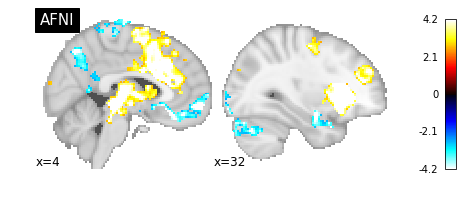

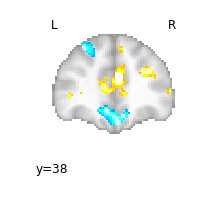

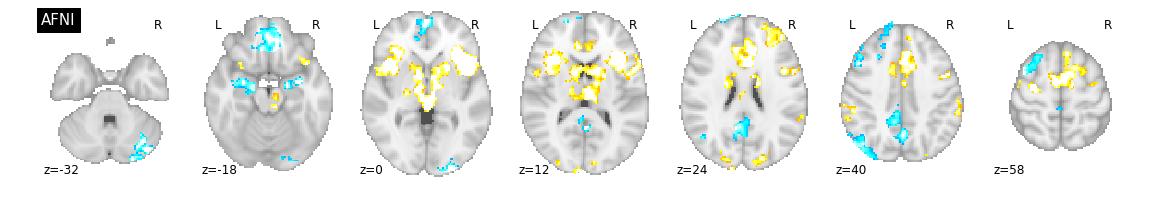

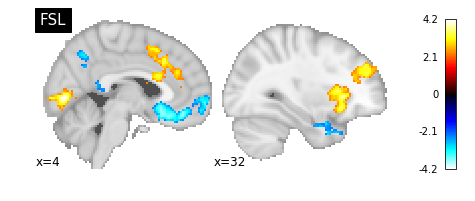

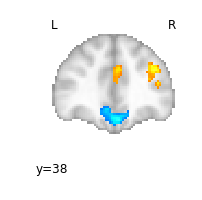

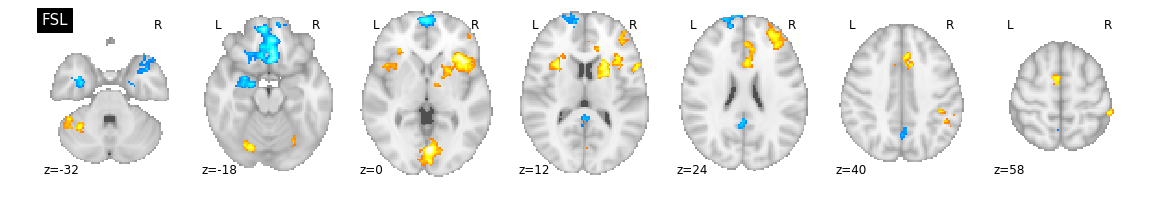

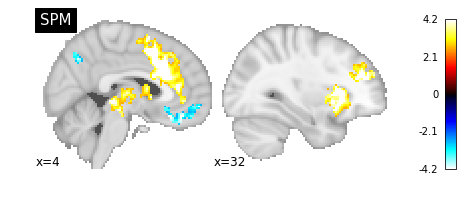

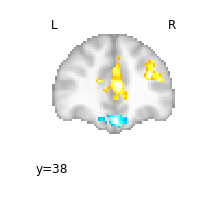

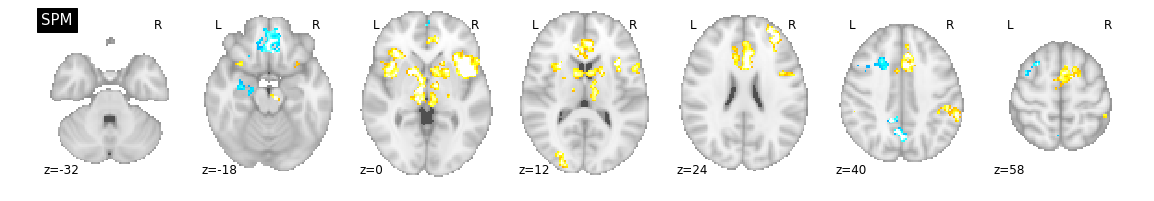

In [136]:
from lib import plot_excursion_sets
# Determine the scale of the activation colorbar
max_activation=4.2
# Determine the coordinates of the x, y, and z axial slices to be displayed
x_coords=[4, 32]
y_coords=[38]
z_coords=[-32, -18, 0, 12, 24, 40, 58]

plot_excursion_sets.plot_excursion_sets(exc_sets, max_activation, x_coords, y_coords, z_coords)

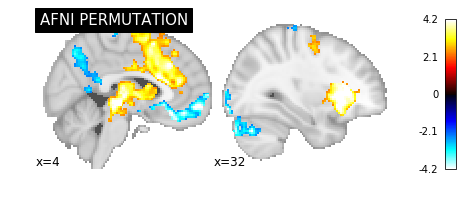

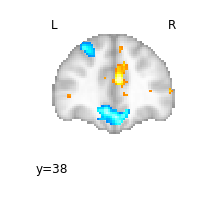

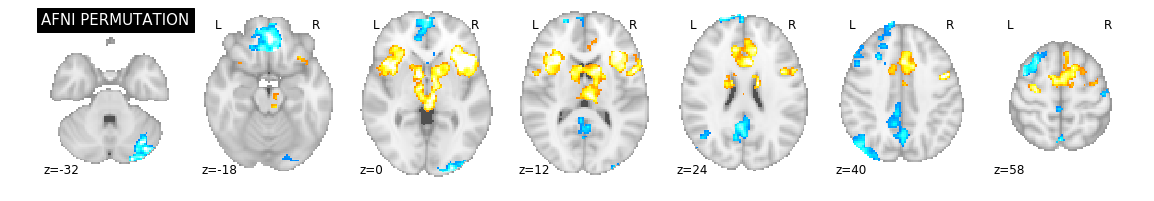

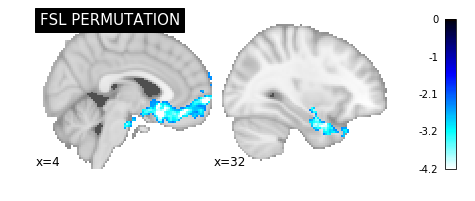

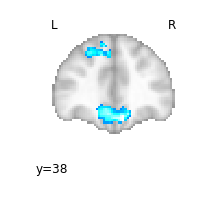

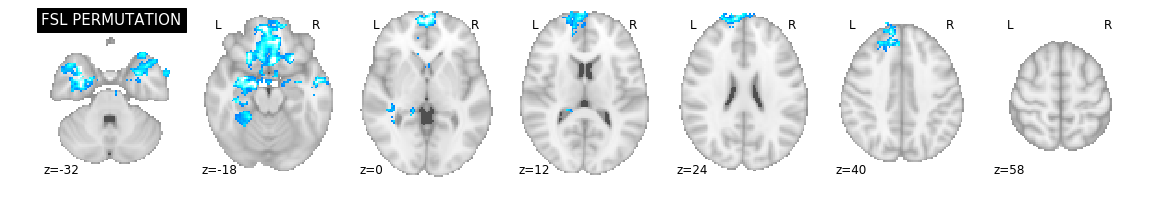

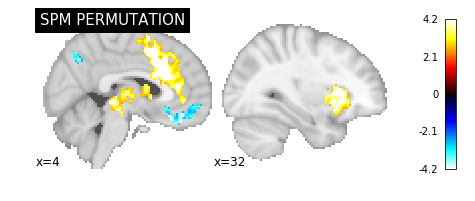

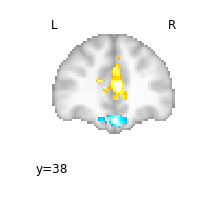

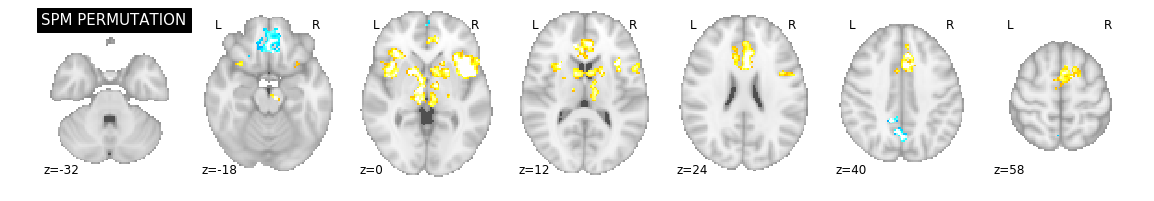

In [137]:
# Plot t-statistic images for permutation test inference results in each software
plot_excursion_sets.plot_excursion_sets(perm_exc_sets, max_activation, x_coords, y_coords, z_coords)

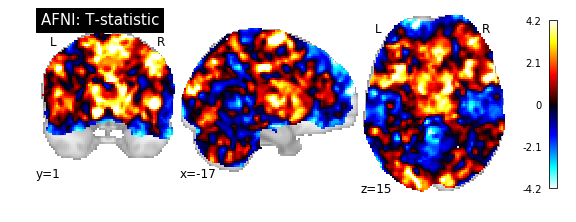

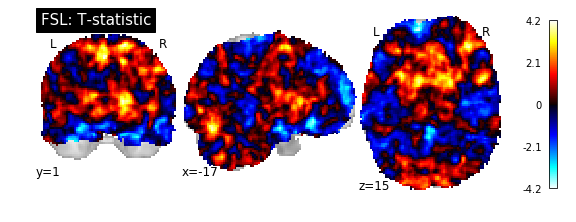

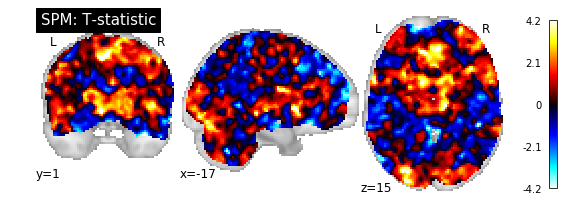

In [138]:
from lib import plot_stat_images
plot_stat_images.plot_stat_images(afni_stat_file, spm_stat_file, max_activation, [-17, 1, 15], 'T-statistic', fsl_stat_file)

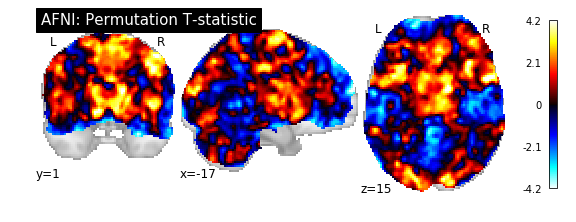

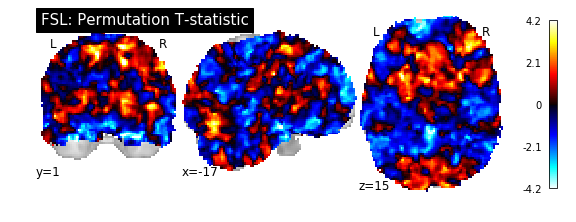

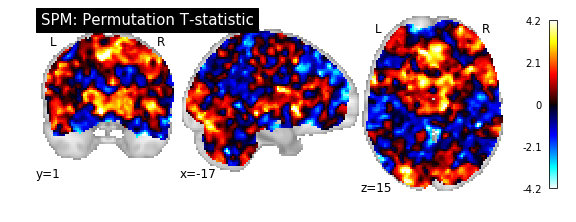

In [139]:
plot_stat_images.plot_stat_images(afni_perm, spm_perm, max_activation, [-17, 1, 15], 'Permutation T-statistic', fsl_perm)

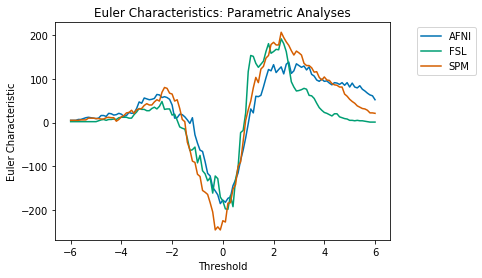

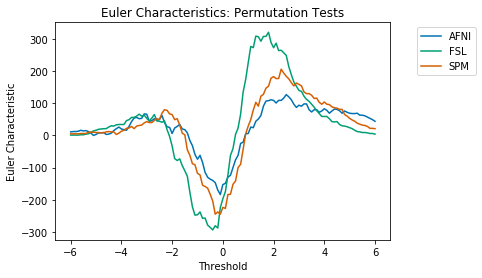

In [140]:
from lib import euler_characteristics
euler_characteristics.euler_characteristics(euler_chars, 'Parametric Analyses')
euler_characteristics.euler_characteristics(perm_euler_chars, 'Permutation Tests')

pixdim[1,2,3] should be positive; setting to abs of pixdim values
pixdim[1,2,3] should be positive; setting to abs of pixdim values


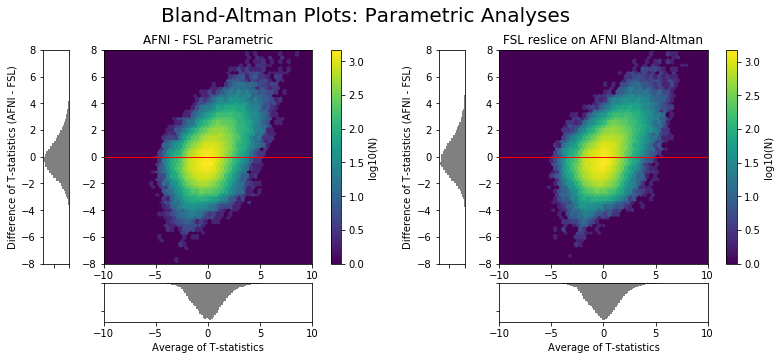

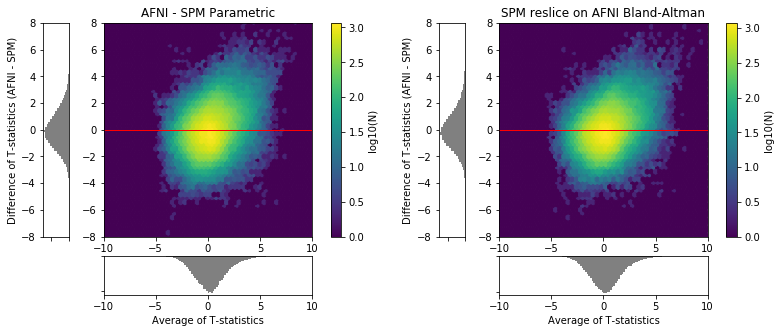

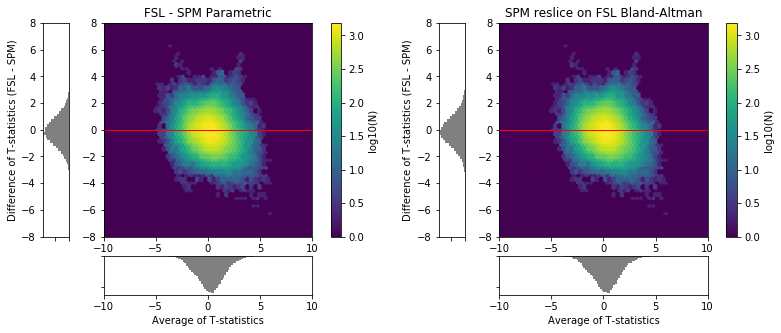

In [141]:
from lib import bland_altman
reload(bland_altman)
bland_altman.bland_altman('Bland-Altman Plots: Parametric Analyses', afni_stat_file, spm_stat_file,
            'AFNI - SPM Parametric', 'AFNI - FSL Parametric', 'FSL - SPM Parametric',
             fsl_stat_file, study=study)

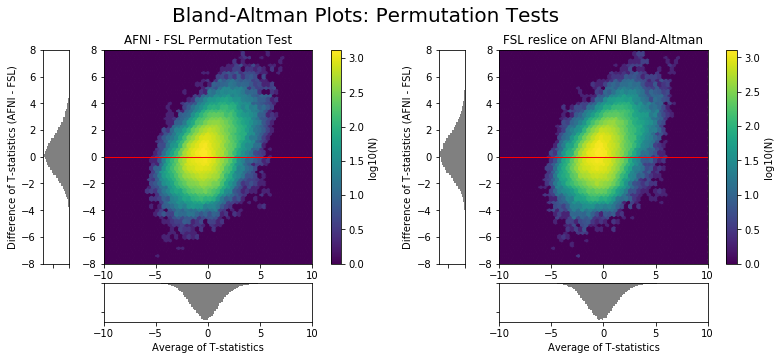

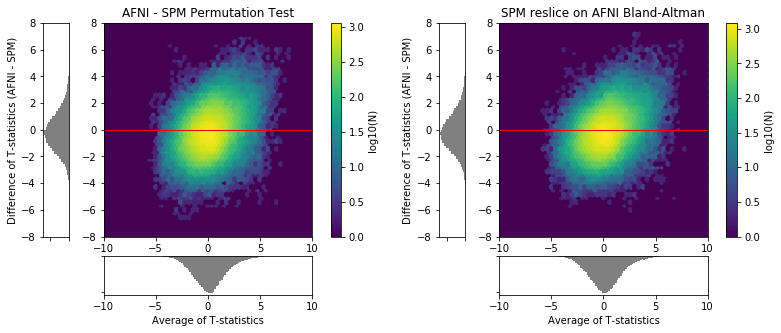

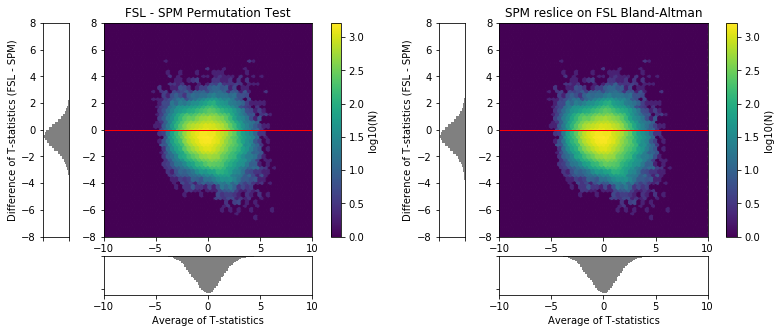

In [142]:
bland_altman.bland_altman('Bland-Altman Plots: Permutation Tests', afni_perm, spm_perm,
            'AFNI - SPM Permutation Test', 'AFNI - FSL Permutation Test', 'FSL - SPM Permutation Test',
             fsl_perm, num_subjects=num_subjects, study=study + '_perm')

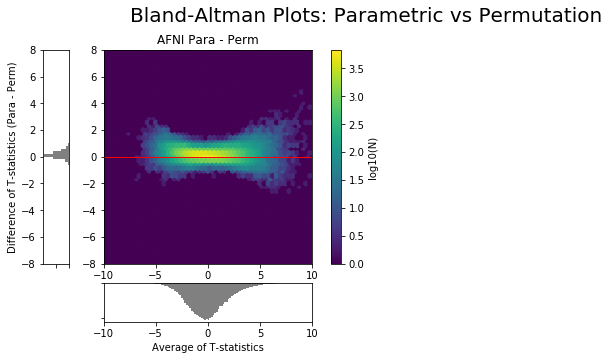

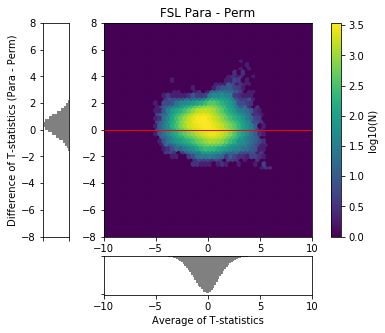

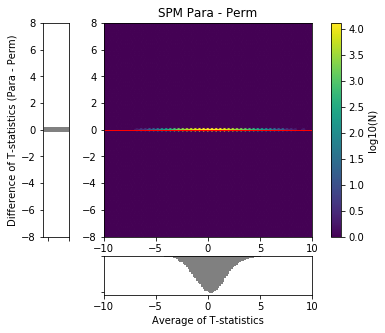

In [143]:
bland_altman.bland_altman_intra('Bland-Altman Plots: Parametric vs Permutation', afni_stat_file, afni_perm,
             fsl_stat_file, fsl_perm,
             spm_stat_file, spm_perm, num_subjects=num_subjects, 
             study=study + '_permintra')

AFNI/FSL positive activation dice coefficient = 0.283569, 2, 0
AFNI/SPM positive activation dice coefficient = 0.471435, 0, 2
FSL/SPM positive activation dice coefficient = 0.381360, 0, 6
Permutation test AFNI/SPM positive activation dice coefficient = 0.509728, 1, 0
Permutation test AFNI/FSL positive activation dice coefficient = 0.000000, 0, 0
Permutation test FSL/SPM positive activation dice coefficient = 0.000000, 0, 0
AFNI classical inference/permutation test positive activation dice coefficient = 0.833208, 0, 0
FSL classical inference/permutation test positive activation dice coefficient = 0.000000, 0, 0
SPM classical inference/permutation test positive activation dice coefficient = 0.920194, 0, 0
AFNI parametric/FSL permutation positive activation dice coefficient = 0.000000, 0, 0
AFNI parametric/SPM permutation positive activation dice coefficient = 0.460962, 1, 2
FSL parametric/AFNI permutation positive activation dice coefficient = 0.292806, 0, 2
FSL parametric/SPM permutatio

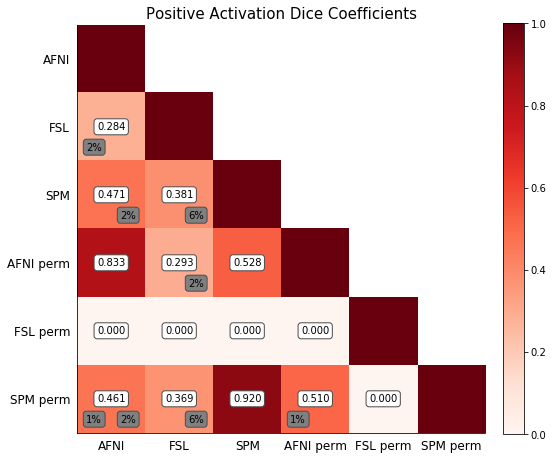

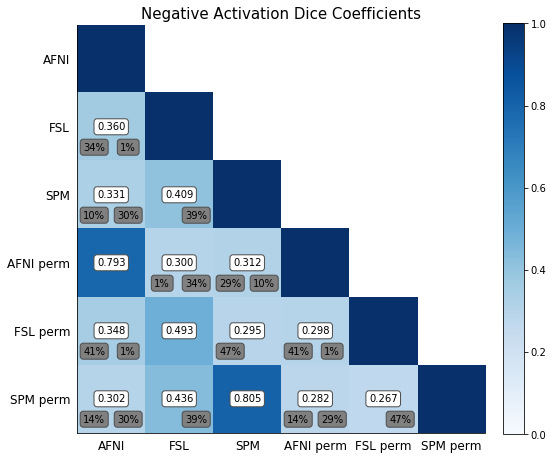

In [144]:
from lib import dice
dice.dice(afni_exc_set_file, spm_exc_set_file, 
         afni_perm_pos_exc, spm_perm_pos_exc,
         afni_exc_set_file_neg, spm_exc_set_file_neg,
         fsl_exc_set_file, fsl_exc_set_file_neg, 
         fsl_perm_pos_exc,
         afni_perm_neg_exc, fsl_perm_neg_exc, spm_perm_neg_exc, study=study,
         afni_stat_file=afni_stat_file, fsl_stat_file=fsl_stat_file, spm_stat_file=spm_stat_file,
         afni_perm=afni_perm, fsl_perm=fsl_perm, spm_perm=spm_perm,)